In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [55]:
sns.set_theme(style="white", palette="magma")
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

In [56]:
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')

df = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)

X = df.drop(columns=['Transported'])
y = train['Transported']

test_set_flag = len(train)

X.shape, y.shape 

((12970, 13), (8693,))

In [57]:
# Name - We assume that people with the same surname belong to the same family
X[['Name', 'Surname']] = X['Name'].str.split(' ', expand=True)
X['FamilySize'] = X['Surname'].map(X.groupby('Surname').size())

# Cabin
X['CabinSize'] = X['Cabin'].map(X.groupby('Cabin').size())
X[['Deck', 'Num', 'Side']] = X['Cabin'].str.split('/', expand=True)
X['Num'] = X['Num'].astype('float64')

# PassengerId
X['Group'] = X['PassengerId'].str.split('_', expand=True)[0]
X['GroupSize'] = X['Group'].map(X.groupby('Group').size())

# New feature - alone
X['Alone'] = (X['FamilySize'] == 1) & (X['GroupSize'] == 1)

# Spending
spending_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
X['TotalSpending'] = X[spending_features].sum(axis=1)
X['NoSpending'] = X['TotalSpending'] == 0

X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Surname,FamilySize,CabinSize,Deck,Num,Side,Group,GroupSize,Alone,TotalSpending,NoSpending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham,Ofracculy,3.0,1.0,B,0.0,P,0001,1,False,0.0,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna,Vines,4.0,1.0,F,0.0,S,0002,1,False,736.0,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark,Susent,7.0,2.0,A,0.0,S,0003,2,False,10383.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam,Susent,7.0,2.0,A,0.0,S,0003,2,False,5176.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy,Santantines,9.0,1.0,F,1.0,S,0004,1,False,1091.0,False


In [58]:
# Change types
X = X.convert_dtypes(infer_objects=True)

# Change int64 features to float64 for numpy compatibility
X[X.select_dtypes(['int64']).columns] = X.select_dtypes(['int64']).astype('float64')
X[X.select_dtypes(['string']).columns] = X.select_dtypes(['string']).astype('category')

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    12970 non-null  category
 1   HomePlanet     12682 non-null  category
 2   CryoSleep      12660 non-null  boolean 
 3   Cabin          12671 non-null  category
 4   Destination    12696 non-null  category
 5   Age            12700 non-null  float64 
 6   VIP            12674 non-null  boolean 
 7   RoomService    12707 non-null  float64 
 8   FoodCourt      12681 non-null  float64 
 9   ShoppingMall   12664 non-null  float64 
 10  Spa            12686 non-null  float64 
 11  VRDeck         12702 non-null  float64 
 12  Name           12676 non-null  category
 13  Surname        12676 non-null  category
 14  FamilySize     12676 non-null  float64 
 15  CabinSize      12671 non-null  float64 
 16  Deck           12671 non-null  category
 17  Num            12671 non-null  

# Exploration

In [59]:
eda_data = pd.concat([X.iloc[:test_set_flag], y], axis=1).drop(columns=['PassengerId', 'Name'])

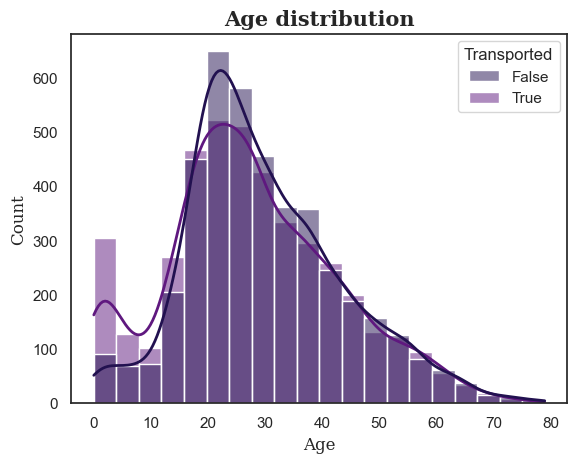

In [60]:
sns.histplot(data=eda_data, x='Age', bins=20, kde=True, hue='Transported')
plt.setp(plt.gca().get_lines(), linewidth=2)
plt.title('Age distribution', fontsize=15, fontweight='bold', fontfamily='serif')
plt.xlabel('Age', fontsize=12, fontfamily='serif')
plt.ylabel('Count', fontsize=12, fontfamily='serif')
plt.savefig('../plots/age_distribution.png')

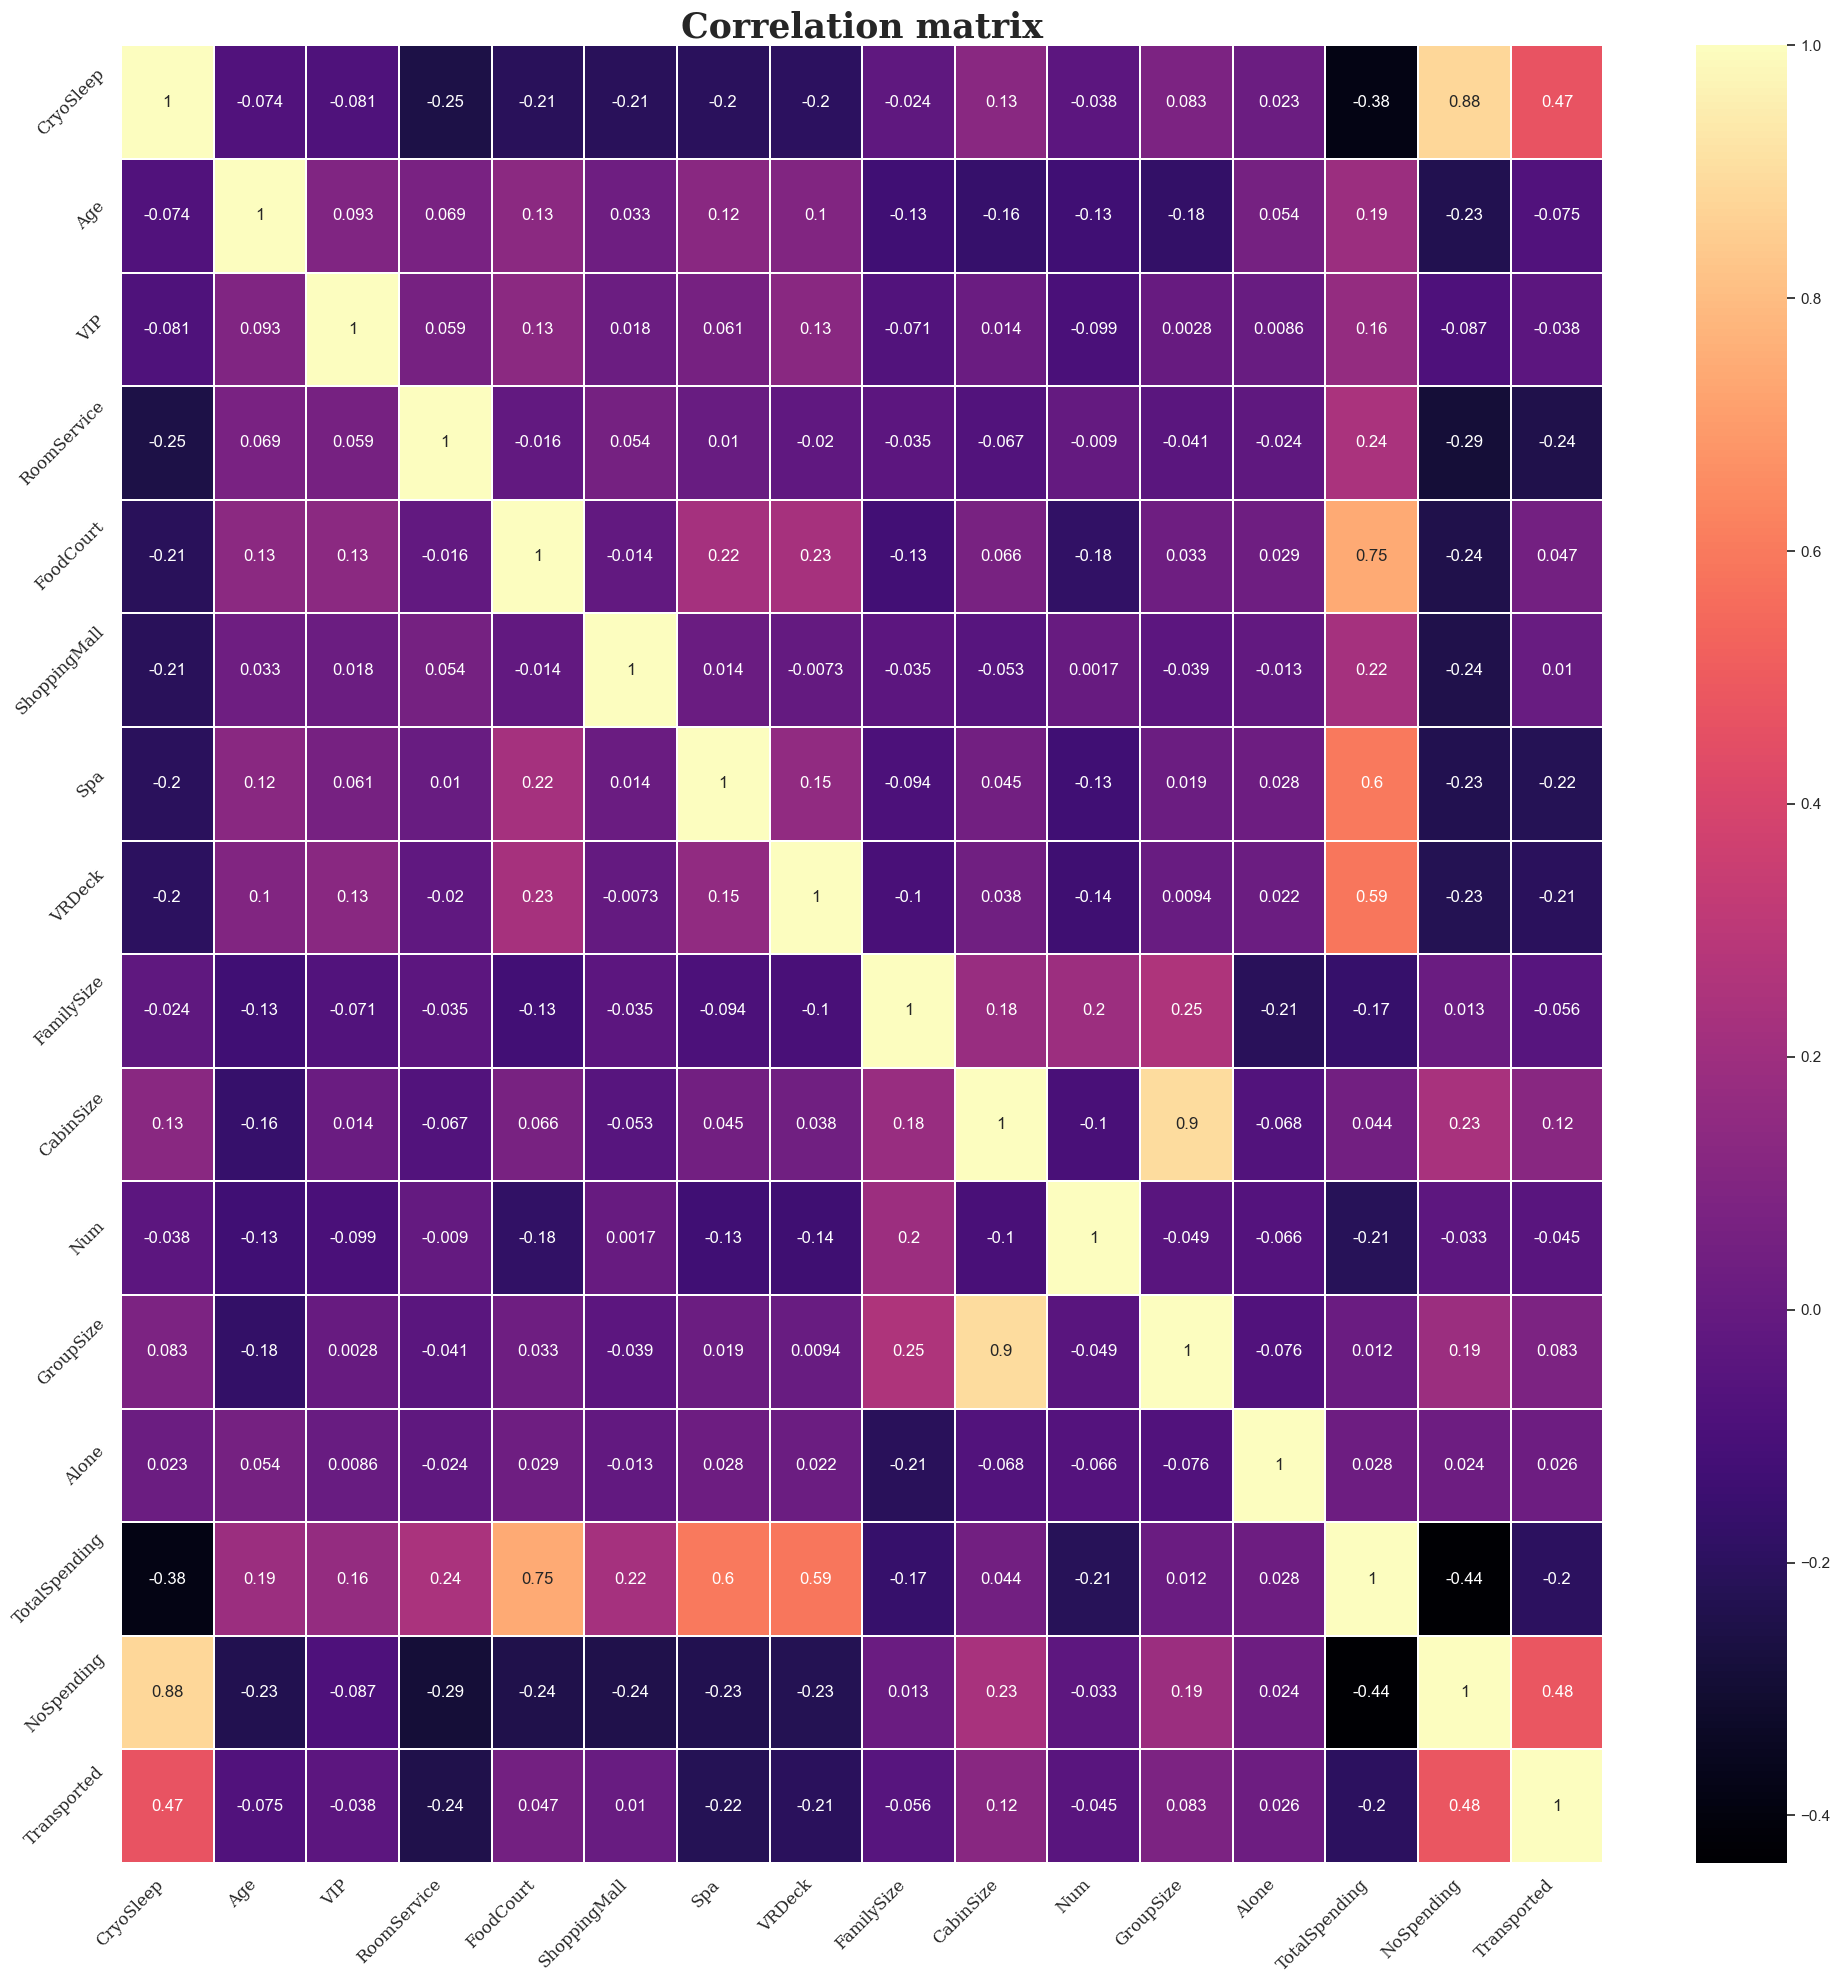

In [61]:
plt.figure(figsize=(20, 20))
sns.heatmap(eda_data.select_dtypes(['float64', 'boolean']).corr(), annot=True, cmap='magma', linewidths=0.1, linecolor='white')
plt.title('Correlation matrix', fontsize=25, fontfamily='serif', fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12, fontfamily='serif')
plt.yticks(rotation=45, ha='right', fontsize=12, fontfamily='serif')
plt.tight_layout()
plt.savefig('../plots/correlation_matrix.png')

In [62]:
categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side']

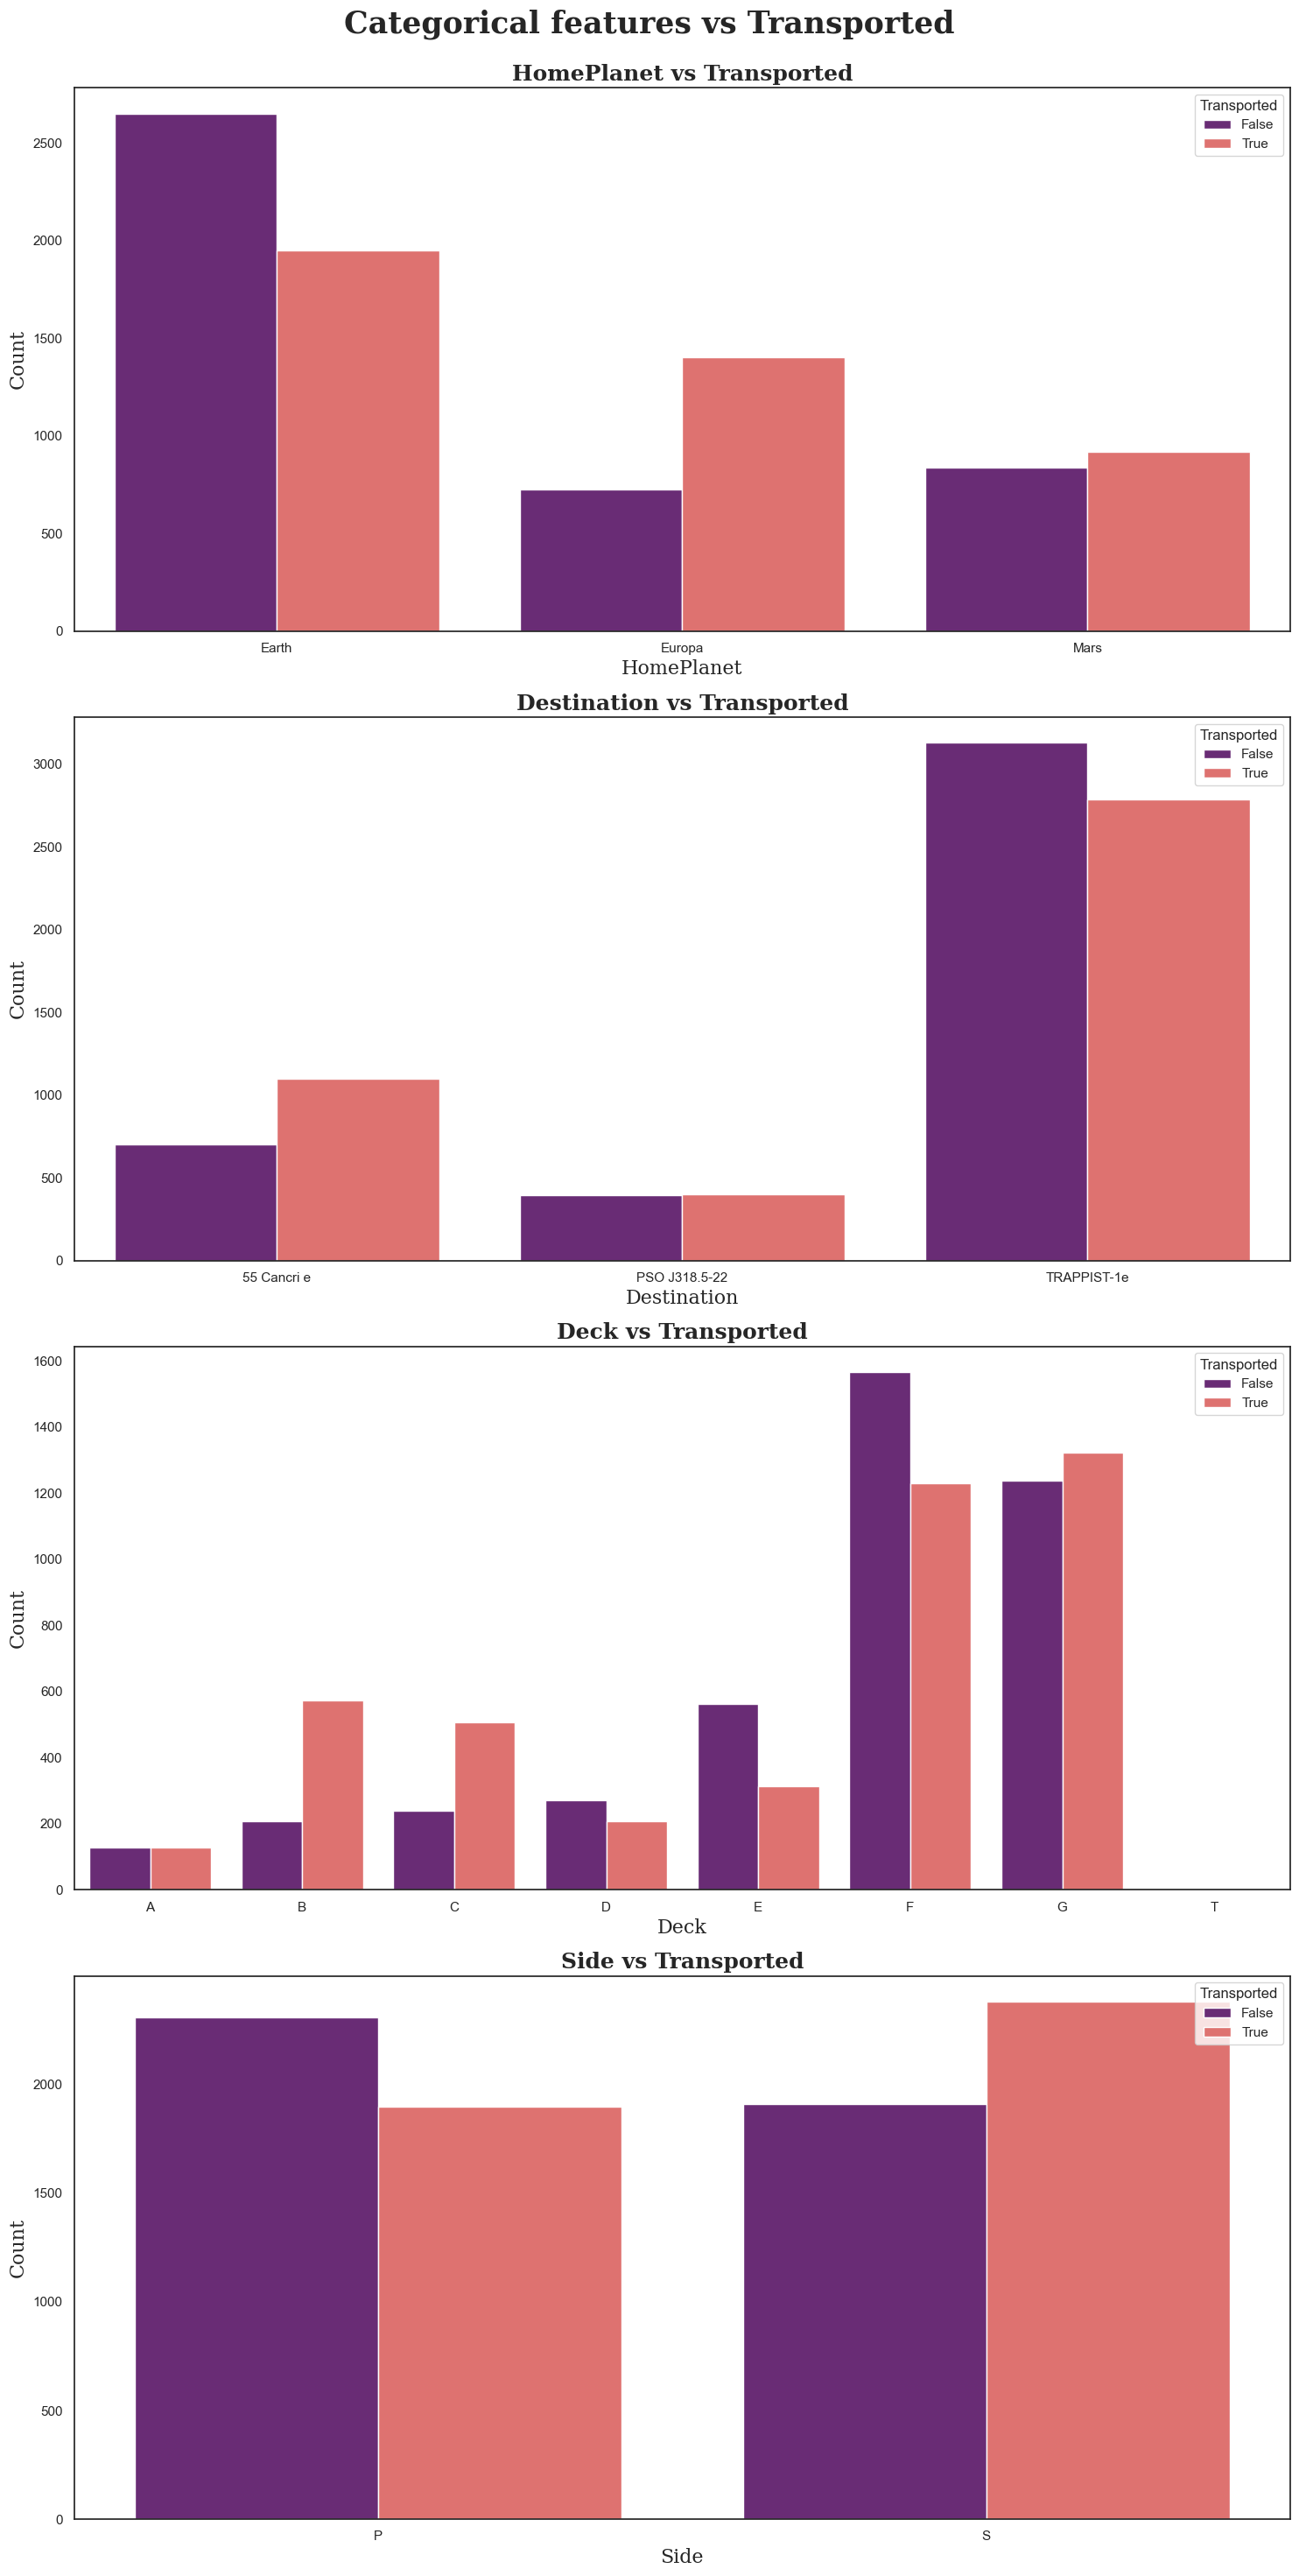

In [63]:
fig, axes = plt.subplots(
    nrows=len(categorical_features), ncols=1, figsize=(15, 30))

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='Transported', data=eda_data,
                  ax=axes[i], palette='magma')
    axes[i].set_title(f"{col} vs Transported", fontsize=18,
                      fontfamily='serif', fontweight='bold')
    axes[i].set_xlabel(col, fontsize=16, fontfamily='serif')
    axes[i].set_ylabel("Count", fontsize=16, fontfamily='serif')
    axes[i].legend(title='Transported', loc='upper right')

plt.suptitle('Categorical features vs Transported',
             fontsize=25, fontfamily='serif', fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

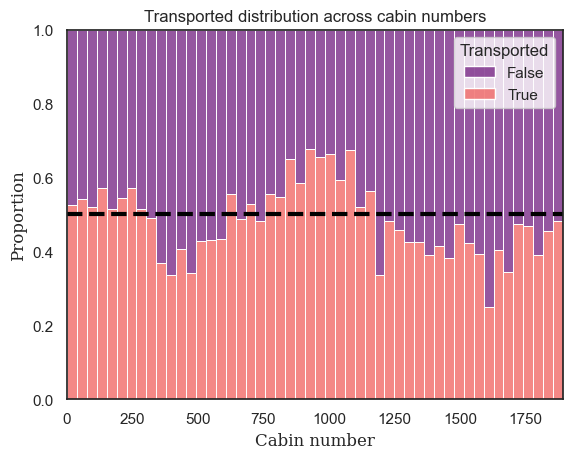

In [64]:
sns.histplot(data=eda_data, x='Num', palette='magma', hue='Transported', fill=True, multiple='fill', bins=50)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=3)
plt.title("Transported distribution across cabin numbers")
plt.xlabel("Cabin number", fontsize=12, fontfamily='serif')
plt.ylabel("Proportion", fontsize=12, fontfamily='serif')
plt.show()

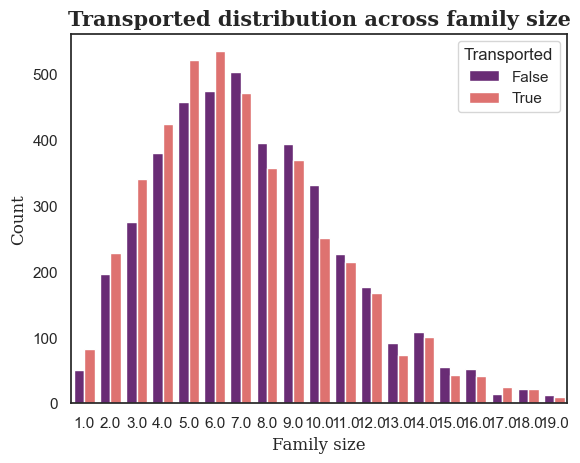

In [65]:
sns.countplot(x='FamilySize', hue='Transported',
              data=eda_data, palette='magma')
plt.title("Transported distribution across family size", fontsize=15, fontfamily='serif', fontweight='bold')
plt.xlabel("Family size", fontsize=12, fontfamily='serif')
plt.ylabel("Count", fontsize=12, fontfamily='serif')
plt.legend(title='Transported', loc='upper right')
plt.show()

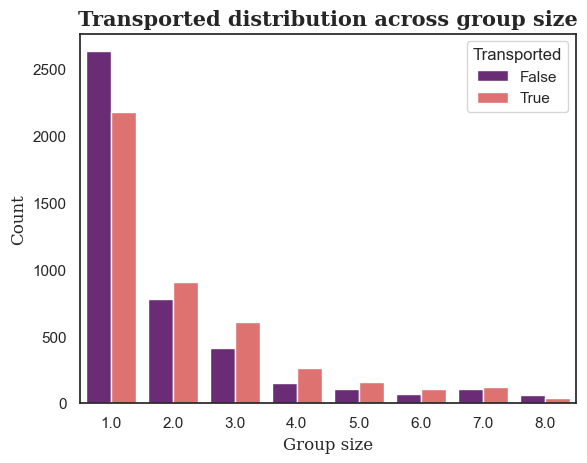

In [66]:
sns.countplot(x='GroupSize', hue='Transported',
              data=eda_data, palette='magma')
plt.title("Transported distribution across group size", fontsize=15, fontfamily='serif', fontweight='bold')
plt.xlabel("Group size", fontsize=12, fontfamily='serif')
plt.ylabel("Count", fontsize=12, fontfamily='serif')
plt.legend(title='Transported', loc='upper right')
plt.show()

In [67]:
# sns.pairplot(pd.concat([eda_data.select_dtypes(['float64']), eda_data['Transported']], axis=1), hue='Transported')
# plt.gcf().set_size_inches(20, 20)
# plt.title('Pairplot')
# plt.show()

# Imputation

In [68]:
print(f"Percentage of cabins consisting of one family: {(X[X['CabinSize'] > 1].groupby('Cabin')['Surname'].nunique() == 1).mean()}")

Percentage of cabins consisting of one family: 0.1386259541984733


Surname by group

In [69]:
print(f"Percentage of groups consisting of one family: {(X[X['GroupSize'] > 1].groupby('Group')['Surname'].nunique() == 1).mean()}")

Percentage of groups consisting of one family: 0.190625


Room by group

In [70]:
print(f"Percentage of families consisting of one deck: {(X[X['FamilySize'] > 1].groupby('Surname')['Deck'].nunique() == 1).mean()}")
print(f"Percentage of families consisting of one Num: {(X[X['FamilySize'] > 1].groupby('Surname')['Num'].nunique() == 1).mean()}")
print(f"Percentage of families consisting of one Side: {(X[X['FamilySize'] > 1].groupby('Surname')['Side'].nunique() == 1).mean()}")

Percentage of families consisting of one deck: 0.15544472152950956
Percentage of families consisting of one Num: 0.05901911886949293
Percentage of families consisting of one Side: 0.23524522028262676


In [71]:
print(f"Percentage of groups consisting of one deck: {(X[X['GroupSize'] > 1].groupby('Group')['Deck'].nunique() == 1).mean()}")
print(f"Percentage of groups consisting of one Num: {(X[X['GroupSize'] > 1].groupby('Group')['Num'].nunique() == 1).mean()}")
print(f"Percentage of groups consisting of one Side: {(X[X['GroupSize'] > 1].groupby('Group')['Side'].nunique() == 1).mean()}")

Percentage of groups consisting of one deck: 0.1574353448275862
Percentage of groups consisting of one Num: 0.15765086206896553
Percentage of groups consisting of one Side: 0.22995689655172413


HomePlanet by deck

Text(0.5, 1.0, 'HomePlanet distribution across decks')

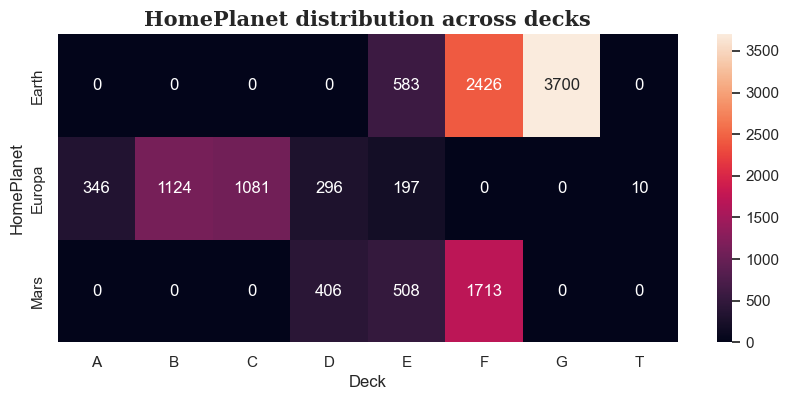

In [72]:
home_decks = X.groupby(['Deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize=(10,4))
sns.heatmap(home_decks.T, annot=True, fmt='g')
plt.title('HomePlanet distribution across decks', fontsize=15, fontweight='bold', fontfamily='serif')

In [73]:
# Missing values before
X['HomePlanet'].isna().sum()

288

In [74]:
mask = X['HomePlanet'].isna() & (X['Deck'] == 'G')
X.loc[mask, 'HomePlanet'] = 'Earth'

mask = X['HomePlanet'].isna() & (X['Deck'].isin(['A', 'B', 'C', 'T']))
X.loc[mask, 'HomePlanet'] = 'Europa'

X['HomePlanet'].isna().sum()

160

Destination by deck

Text(0.5, 1.0, 'Destination distribution across decks')

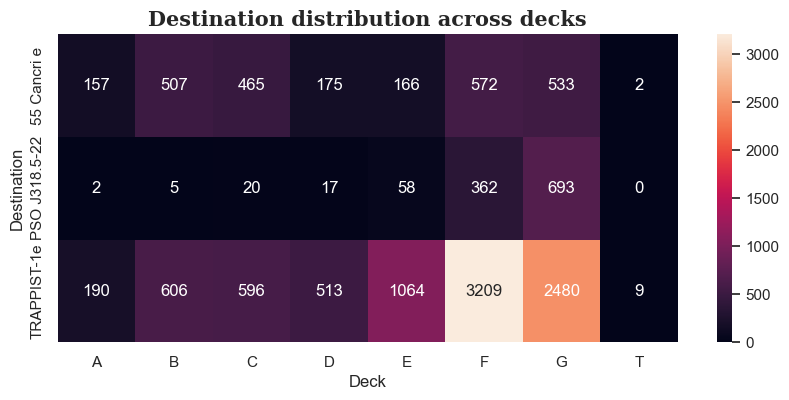

In [75]:
dest_decks = X.groupby(['Deck','Destination'])['Destination'].size().unstack().fillna(0)

plt.figure(figsize=(10,4))
sns.heatmap(dest_decks.T, annot=True, fmt='g')
plt.title('Destination distribution across decks', fontsize=15, fontweight='bold', fontfamily='serif')

In [76]:
# Missing values before
X['Destination'].isna().sum()

274

In [77]:
mask = X['Destination'].isna() & (X['Deck'].isin(['E', 'F', 'G']))
X.loc[mask, 'Destination'] = 'TRAPPIST-1e'

X['Destination'].isna().sum()

68

HomePlanet by Surname

In [78]:
print(f"Percentage of groups consisting of one HomePlanet: {(X[X['GroupSize'] > 1].groupby('Group')['HomePlanet'].nunique() == 1).mean()}")
print(f"Percentage of families consisting of one HomePlanet: {(X[X['FamilySize'] > 1].groupby('Group')['HomePlanet'].nunique() == 1).mean()}")

Percentage of groups consisting of one HomePlanet: 0.22995689655172413
Percentage of families consisting of one HomePlanet: 0.9535560344827586


In [79]:
family_planets = (X.groupby(['Surname', 'HomePlanet'])['HomePlanet'].
                    size().
                    unstack().
                    idxmax(axis='columns')
                  )
X['HomePlanet'].isna().sum()

160

In [80]:
mask = X['HomePlanet'].isna() & X['Surname'].isin(family_planets.index)

X.loc[mask, 'HomePlanet'] = X.loc[mask, 'Surname'].map(family_planets)
X['HomePlanet'].isna().sum()

8

There is much more insight hidden in the data, that could aid it's imputation, also the hyperparameters need more extensive tuning.

VIP

Text(0.5, 1.0, 'VIP status by age')

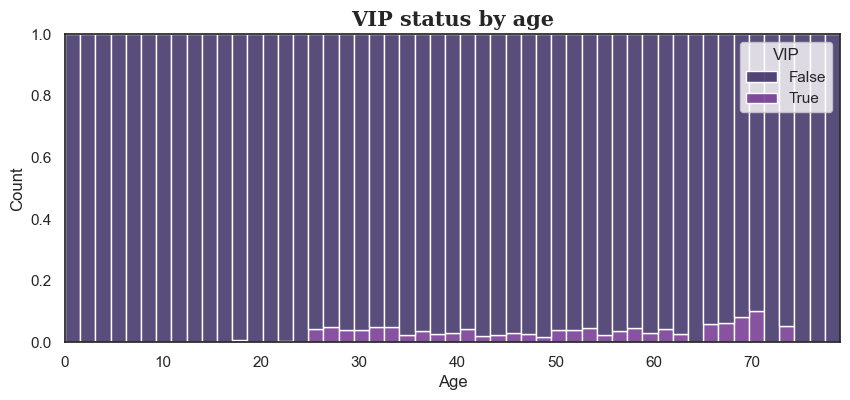

In [81]:
plt.figure(figsize=(10,4))
sns.histplot(data=X.dropna(subset=['Age', 'VIP']), x="Age", multiple="fill", hue="VIP")
plt.title('VIP status by age', fontsize=15, fontweight='bold', fontfamily='serif')

Text(0.5, 1.0, 'VIP status by HomePlanet')

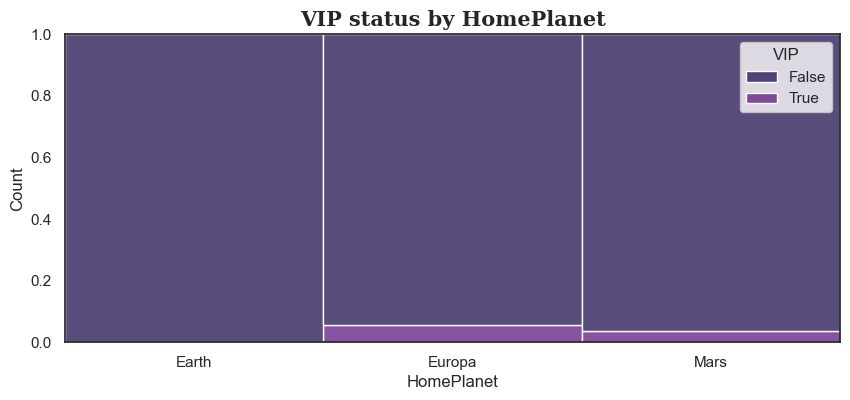

In [82]:
plt.figure(figsize=(10,4))
sns.histplot(data=X.dropna(subset=['HomePlanet', 'VIP']), x="HomePlanet", multiple="fill", hue="VIP")
plt.title('VIP status by HomePlanet', fontsize=15, fontweight='bold', fontfamily='serif')

In [83]:
X['VIP'].isna().sum()

296

In [84]:
# There aren't VIP passenger in Earth and There aren't any VIP passengers under 18 years age.
# Some of the missing values can be filled according to this determination

mask = X['VIP'].isna() & (X['HomePlanet'] == 'Earth')
X.loc[mask, 'VIP'] = False

mask = X['VIP'].isna() & (X['Age'] < 18)
X.loc[mask, 'VIP'] = False

X['VIP'].isna().sum()

123

VIP by group

In [85]:
print(f"Money spent by sleeping passengers: {X[X['CryoSleep'] == True]['TotalSpending'].sum()}")

Money spent by sleeping passengers: 0.0


In [86]:
print(f"Percentage of groups where everyone is a VIP: {(X[X['GroupSize'] > 1].groupby('Group')['VIP'].nunique() == 1).mean()}")

Percentage of groups where everyone is a VIP: 0.21422413793103448


In [87]:
# Passengers under 13 years of age  and sleeping passengers don't have any spend
#  Some of the missing values can be filled according to this determination

for feature in spending_features:
    AgeSpendingIndex = X[(X[feature].isnull() == True) & (X["Age"]<13)][[feature]].index
    X[feature][AgeSpendingIndex] = 0
    SleepingSpendingIndex = X[(X[feature].isnull() == True) & (X["CryoSleep"] == True)][[feature]].index
    X[feature][SleepingSpendingIndex] = 0
    
# update total spending
X['TotalSpending'] = X[spending_features].sum(axis=1)

X[spending_features].isna().sum()

RoomService     162
FoodCourt       171
ShoppingMall    163
Spa             166
VRDeck          150
dtype: int64

CryoSleep by Spending

In [88]:
# Percentage of sleeping passengers among those with zero spending
print(f"Percentage of sleeping passengers among those with zero spending: {(X[X['TotalSpending'] == 0]['CryoSleep'] == True).mean()}")

Percentage of sleeping passengers among those with zero spending: 0.8609283969178726


# New features

In [89]:
X['DeckNumSide'] = X['Deck'].astype('str') + X['Num'].astype('str') + X['Side'].astype('str')

X['FamilySize'] = X['Surname'].map(X.groupby('Surname').size())
X['GroupSize'] = X['Group'].map(X.groupby('Group').size())
X['CabinSize'] = X['DeckNumSide'].map(X.groupby('DeckNumSide').size())
X['TotalSpending'] = X[spending_features].sum(axis=1)
X['Alone'] = (X['FamilySize'] == 1) & (X['GroupSize'] == 1)
X['NoSpending'] = X['TotalSpending'] == 0

X = X.drop(columns=['DeckNumSide'])

# Drop irrelevant features

In [90]:
X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Surname,FamilySize,CabinSize,Deck,Num,Side,Group,GroupSize,Alone,TotalSpending,NoSpending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham,Ofracculy,3.0,1.0,B,0.0,P,0001,1,False,0.0,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna,Vines,4.0,1.0,F,0.0,S,0002,1,False,736.0,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark,Susent,7.0,2.0,A,0.0,S,0003,2,False,10383.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam,Susent,7.0,2.0,A,0.0,S,0003,2,False,5176.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy,Santantines,9.0,1.0,F,1.0,S,0004,1,False,1091.0,False


In [91]:
X = X.drop(columns = ['PassengerId', 'Cabin', 'Name'])

In [92]:
X.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Surname', 'FamilySize',
       'CabinSize', 'Deck', 'Num', 'Side', 'Group', 'GroupSize', 'Alone',
       'TotalSpending', 'NoSpending'],
      dtype='object')

In [93]:
print(X["Group"].nunique())
print(X["GroupSize"].nunique())
print(X["Surname"].nunique())
print(X["Num"].nunique())
print(X["Age"].nunique())

X['Age'] = X['Age'].astype('category')

9280
8
2406
1894
80


In [94]:
from category_encoders import MEstimateEncoder

X['Transported'] = y
y = X.pop("Transported")

encoders = MEstimateEncoder(cols = ["Group", "Surname", "Num", "Age"], m=4.0)
encoders.fit(X, y)
X = encoders.transform(X)

In [95]:
print(X["Group"].nunique())
print(X["GroupSize"].nunique())
print(X["Surname"].nunique())
print(X["Num"].nunique())
print(X["Age"].nunique())

40
8
85
126
79


## KNN Imputation of the rest

In [96]:

X['Group'] = X['Group'].astype('float64')
X['Surname'] = X['Surname'].astype('float64')

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   HomePlanet     12962 non-null  category
 1   CryoSleep      12660 non-null  boolean 
 2   Destination    12902 non-null  category
 3   Age            12970 non-null  object  
 4   VIP            12847 non-null  boolean 
 5   RoomService    12808 non-null  float64 
 6   FoodCourt      12799 non-null  float64 
 7   ShoppingMall   12807 non-null  float64 
 8   Spa            12804 non-null  float64 
 9   VRDeck         12820 non-null  float64 
 10  Surname        12970 non-null  float64 
 11  FamilySize     12676 non-null  float64 
 12  CabinSize      12671 non-null  float64 
 13  Deck           12671 non-null  category
 14  Num            12970 non-null  object  
 15  Side           12671 non-null  category
 16  Group          12970 non-null  float64 
 17  GroupSize      12970 non-null  

In [97]:
# One-hot encoding of categorical features
X = pd.get_dummies(X, columns=X.select_dtypes(['category']).columns)
X

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Surname,FamilySize,CabinSize,Num,Group,GroupSize,Alone,TotalSpending,NoSpending,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,False,0.450806,False,0.0,0.0,0.0,0.0,0.0,0.402899,3.0,1.0,0.364295,0.402899,1,False,0.0,True,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0
1,False,0.432971,False,109.0,9.0,25.0,549.0,44.0,0.751812,4.0,1.0,0.364295,0.602899,1,False,736.0,False,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,False,0.510088,True,43.0,3576.0,0.0,6715.0,49.0,0.501449,7.0,2.0,0.364295,0.335749,2,False,10383.0,False,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1
3,False,0.467113,False,0.0,1283.0,371.0,3329.0,193.0,0.501449,7.0,2.0,0.364295,0.335749,2,False,5176.0,False,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1
4,False,0.543142,False,303.0,70.0,151.0,565.0,2.0,0.501449,9.0,1.0,0.632342,0.602899,1,False,1091.0,False,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,True,0.519832,False,0.0,0.0,0.0,0.0,0.0,0.501449,10.0,1.0,0.573499,0.503624,2,False,0.0,True,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
12966,False,0.447272,False,0.0,847.0,17.0,10.0,144.0,0.251812,6.0,NaN,0.502534,0.503624,1,False,1018.0,False,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
12967,True,0.502811,False,0.0,0.0,0.0,0.0,0.0,0.503624,4.0,1.0,0.455863,0.503624,1,False,0.0,True,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0
12968,False,0.502811,False,0.0,2680.0,0.0,0.0,523.0,0.669082,7.0,1.0,0.715321,0.503624,1,False,3203.0,False,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [98]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Surname,FamilySize,CabinSize,Num,Group,GroupSize,Alone,TotalSpending,NoSpending,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0.0,0.450806,0.0,0.0,0.0,0.0,0.0,0.0,0.402899,3.0,1.0,0.364295,0.402899,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.432971,0.0,109.0,9.0,25.0,549.0,44.0,0.751812,4.0,1.0,0.364295,0.602899,1.0,0.0,736.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.510088,1.0,43.0,3576.0,0.0,6715.0,49.0,0.501449,7.0,2.0,0.364295,0.335749,2.0,0.0,10383.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.467113,0.0,0.0,1283.0,371.0,3329.0,193.0,0.501449,7.0,2.0,0.364295,0.335749,2.0,0.0,5176.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.543142,0.0,303.0,70.0,151.0,565.0,2.0,0.501449,9.0,1.0,0.632342,0.602899,1.0,0.0,1091.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,1.0,0.519832,0.0,0.0,0.0,0.0,0.0,0.0,0.501449,10.0,1.0,0.573499,0.503624,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
12966,0.0,0.447272,0.0,0.0,847.0,17.0,10.0,144.0,0.251812,6.0,1.0,0.502534,0.503624,1.0,0.0,1018.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12967,1.0,0.502811,0.0,0.0,0.0,0.0,0.0,0.0,0.503624,4.0,1.0,0.455863,0.503624,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12968,0.0,0.502811,0.0,0.0,2680.0,0.0,0.0,523.0,0.669082,7.0,1.0,0.715321,0.503624,1.0,0.0,3203.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Prepare for training

In [99]:
X_train, X_test = X.iloc[ :test_set_flag, :], X.iloc[test_set_flag: , :]
y_train = y.iloc[ :test_set_flag]

In [100]:
X_test = X_test.reset_index(drop=True)
len(X_test)

4277

In [101]:
y_train = y_train.astype('int64')

In [102]:
# Remove outliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=42, contamination=0.01)
clf.fit(X_train)
y_pred = clf.predict(X_train)

X_train = X_train[y_pred == 1]
y_train = y_train[y_pred == 1]

print(X_train.shape, y_train.shape)
print(X_test.shape)

(8606, 33) (8606,)
(4277, 33)


In [103]:
# Standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Surname,FamilySize,CabinSize,Num,Group,GroupSize,Alone,TotalSpending,NoSpending,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,-0.755604,-0.644442,-0.142577,-0.341178,-0.289855,-0.284917,-0.284734,-0.275950,-0.754971,-1.224793,-0.582293,-1.199402,-0.923346,-0.644896,-0.113261,-0.556145,1.164696,-1.099257,1.766818,-0.514991,-0.503230,-0.318587,0.653965,-0.166079,3.227041,-0.301702,-0.241699,-0.335781,-0.693347,-0.650527,-0.024111,1.035007,-0.988447
1,-0.755604,-0.862683,-0.142577,-0.168646,-0.283306,-0.242938,0.284514,-0.228100,1.926277,-0.936522,-0.582293,-1.199402,0.788520,-0.644896,-0.113261,-0.242473,-0.858593,0.909706,-0.565989,-0.514991,-0.503230,-0.318587,0.653965,-0.166079,-0.309881,-0.301702,-0.241699,-0.335781,1.442280,-0.650527,-0.024111,-0.966177,1.011688
2,-0.755604,-0.444911,-0.142577,-0.341178,0.643776,0.338063,3.167043,-0.066064,0.002348,-0.071709,0.170616,-1.199402,-1.498103,-0.016146,-0.113261,1.649786,-0.858593,-1.099257,1.766818,-0.514991,-0.503230,-0.318587,0.653965,6.021247,-0.309881,-0.301702,-0.241699,-0.335781,-0.693347,-0.650527,-0.024111,-0.966177,1.011688
3,-0.755604,0.485425,-0.142577,0.138428,-0.238916,-0.031359,0.301104,-0.273775,0.002348,0.504832,-0.582293,1.008862,0.788520,-0.644896,-0.113261,-0.091178,-0.858593,0.909706,-0.565989,-0.514991,-0.503230,-0.318587,0.653965,-0.166079,-0.309881,-0.301702,-0.241699,-0.335781,1.442280,-0.650527,-0.024111,-0.966177,1.011688
4,-0.755604,0.524557,-0.142577,-0.341178,0.061621,-0.284917,0.016999,-0.275950,0.350635,0.793103,-0.582293,-1.199402,0.788520,-0.644896,-0.113261,-0.226278,-0.858593,0.909706,-0.565989,-0.514991,-0.503230,3.138863,-1.529133,-0.166079,-0.309881,-0.301702,-0.241699,-0.335781,1.442280,-0.650527,-0.024111,1.035007,-0.988447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8601,-0.755604,-0.663175,-0.142577,-0.341178,2.044587,-0.284917,-0.282660,0.082923,0.965705,-0.359980,0.923526,0.747195,0.536878,0.612604,-0.113261,0.952548,-0.858593,-1.099257,1.766818,-0.514991,-0.503230,-0.318587,0.653965,6.021247,-0.309881,-0.301702,-0.241699,-0.335781,-0.693347,-0.650527,-0.024111,1.035007,-0.988447
8602,1.329005,-0.041937,-0.142577,-0.341178,-0.289855,-0.284917,-0.284734,-0.275950,-1.270988,-0.648251,-0.582293,-1.434575,-0.923346,-0.644896,-0.113261,-0.556145,1.164696,0.909706,-0.565989,-0.514991,-0.503230,3.138863,-1.529133,-0.166079,-0.309881,-0.301702,-0.241699,-0.335781,-0.693347,1.537216,-0.024111,-0.966177,1.011688
8603,-0.755604,-0.311755,-0.142577,-0.341178,-0.289855,2.858532,-0.283697,-0.275950,2.307721,0.216562,-0.582293,-0.652813,0.788520,-0.644896,-0.113261,0.242099,-0.858593,0.909706,-0.565989,-0.514991,-0.503230,-0.318587,0.653965,-0.166079,-0.309881,-0.301702,-0.241699,-0.335781,-0.693347,1.537216,-0.024111,-0.966177,1.011688
8604,-0.755604,-0.795088,-0.142577,-0.341178,0.473496,-0.284917,0.081285,3.242096,-1.534566,-0.071709,0.170616,-0.652813,-0.071549,-0.016146,-0.113261,1.420072,-0.858593,-1.099257,1.766818,-0.514991,1.987164,-0.318587,-1.529133,-0.166079,-0.309881,-0.301702,-0.241699,2.978131,-0.693347,-0.650527,-0.024111,-0.966177,1.011688


# Models

In [104]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

cv_results = cross_val_score(knn, X_train, y_train, cv=5, scoring="accuracy")
cv_results.mean()

0.9252859228185543

In [106]:
knn_params = {
    "n_neighbors": range(1,7),
    "weights": ["uniform", "distance"],
    "leaf_size": range(1,7)
}

In [107]:
knn_cv = GridSearchCV(knn, knn_params, cv = 5, n_jobs=-1, verbose =2)
knn_cv.fit(X_train, y_train)
knn_cv.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'leaf_size': 1, 'n_neighbors': 6, 'weights': 'distance'}

In [108]:
knn_tuned= KNeighborsClassifier(
    n_neighbors=6,
    weights="distance",
    leaf_size=1
)
knn_tuned.fit(X_train, y_train)

cv_results = cross_val_score(knn_tuned, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9269117845663507

In [109]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1, max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)

cv_results = cross_val_score(lr, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9420159090295221

In [110]:
# lr_params = {
#     "C": np.logspace(-4, 4, 20),
#     "penalty": ["l1", "l2", "elasticnet"],
#     "solver": ["liblinear", "lbfgs", "saga", "newton-cg"]
# }
# 
# lr_cv = GridSearchCV(lr, lr_params, cv = 5, n_jobs=-1, verbose =2)
# lr_cv.fit(X_train, y_train)
# lr_cv.best_params_


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


{'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'liblinear'}

In [111]:
lr_tuned = LogisticRegression(C = 0.08858667904100823, penalty = 'l1', solver = 'liblinear', random_state=42, max_iter=1000)
lr_tuned.fit(X_train, y_train)

y_pred = lr_tuned.predict(X_test)

cv_results = cross_val_score(lr_tuned, X_train, y_train, cv=5, scoring="accuracy")
cv_results.mean()

0.9420183549390903

In [112]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42, n_jobs=-1)
sgd.fit(X_train, y_train)

cv_results = cross_val_score(sgd, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9363221510952652

In [ ]:
# sgd_params = {
#     "loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
#     "penalty": ["l1", "l2", "elasticnet"],
#     "alpha": np.logspace(-4, 4, 20),
#     "learning_rate": ["constant", "optimal", "invscaling", "adaptive"]
# }
# 
# sgd_cv = GridSearchCV(sgd, sgd_params, cv = 5, n_jobs=-1, verbose =2)
# sgd_cv.fit(X_train, y_train)
# 
# sgd_cv.best_params_

In [ ]:
# sgd_tuned = SGDClassifier(
#     random_state=42,
#     n_jobs=-1,
#     **sgd_cv.best_params_
# )
# 
# sgd_tuned.fit(X_train, y_train)
# 
# cv_results = cross_val_score(sgd_tuned, X_train, y_train, cv=10, scoring="accuracy")
# cv_results.mean()

In [113]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

cv_results = cross_val_score(nb, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.8742866596440052

In [114]:
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(X_train, y_train)

cv_results = cross_val_score(svc, X_train, y_train, cv=5, scoring="accuracy")
cv_results.mean()

0.9494548114734904

In [ ]:
# svc_params = {
#     "C": np.logspace(-4, 4, 20),
#     "kernel": ["linear", "poly", "rbf", "sigmoid"],
#     "gamma": ["scale", "auto"]
# }
# 
# svc_cv = GridSearchCV(svc, svc_params, cv = 5, n_jobs=-1, verbose =2)
# svc_cv.fit(X_train, y_train)
# 
# svc_cv.best_params_

In [ ]:
# svc_tuned = SVC(
#     random_state=42,
#     **svc_cv.best_params_
# )
# 
# svc_tuned.fit(X_train, y_train)
# 
# cv_results = cross_val_score(svc_tuned, X_train, y_train, cv=10, scoring="accuracy")
# cv_results.mean()

In [115]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

cv_results = cross_val_score(dt, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9319046268535776

In [116]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)

cv_results = cross_val_score(ada, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9464312724522594

In [117]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

cv_results = cross_val_score(gb, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9500341679496531

In [118]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

cv_results = cross_val_score(rf, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9479422251033143

In [119]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(random_state=42)
et.fit(X_train, y_train)

cv_results = cross_val_score(et, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.947128946870864

In [120]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
hgb.fit(X_train, y_train)

cv_results = cross_val_score(hgb, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9501499068146828

In [121]:
import xgboost as xgb

xgbc = xgb.XGBClassifier(random_state=42)
xgbc.fit(X_train, y_train)

cv_results = cross_val_score(xgbc, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9506158334008589

In [122]:
import lightgbm as lgb

lgbc = lgb.LGBMClassifier(random_state=42)
lgbc.fit(X_train, y_train)

cv_results = cross_val_score(lgbc, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

[LightGBM] [Info] Number of positive: 4364, number of negative: 4242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 8606, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507088 -> initscore=0.028354
[LightGBM] [Info] Start training from score 0.028354
[LightGBM] [Info] Number of positive: 3928, number of negative: 3817
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 7745, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507166 -> initscore=0.028666
[LightGBM] 

0.9504987440239849

In [123]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(random_state=42, verbose=False)
cbc.fit(X_train, y_train)

cv_results = cross_val_score(cbc, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9516607244145531

In [126]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(base_estimator=cbc, n_estimators=10, random_state=42, n_jobs=-1)
bc.fit(X_train, y_train)

cv_results = cross_val_score(bc, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9521244901817789

# Meta-classifiers

In [127]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[('knn', knn_tuned), ('bc', bc), ('sgd', sgd), ('svc', svc), ('ada', ada), ('rf', rf), ('lgbc', lgbc), ('cbc', cbc)], voting='hard', n_jobs=-1)
vc.fit(X_train, y_train)

cv_results = cross_val_score(vc, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9515440401912325

In [128]:
from sklearn.ensemble import StackingClassifier

sc = StackingClassifier(estimators=[('knn', knn_tuned), ('bc', bc), ('sgd', sgd), ('svc', svc), ('ada', ada), ('rf', rf), ('lgbc', lgbc), ('cbc', cbc)], final_estimator=cbc, n_jobs=-1)
sc.fit(X_train, y_train)

cv_results = cross_val_score(sc, X_train, y_train, cv=10, scoring="accuracy")
cv_results.mean()

0.9515440401912324